## Setup and download packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 11.6MB/s 
     |████████████████████████████████| 890kB 32.0MB/s 
     |████████████████████████████████| 3.2MB 49.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=d142cf620b46717131ce8fea9b60b7046526d53bea8a7875be89a8b6a01c22e4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import re
import pandas as pd
import numpy as np
import io
from google.colab import files
import os
import datetime
import time
import sys
import math
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel, T5Tokenizer, TFT5ForConditionalGeneration
import pickle
from sklearn.model_selection import train_test_split

## Read in dataset and clean

In [ ]:
data = pd.read_csv('drive/My Drive/W266 Project/data_augmented_copy.csv')

In [ ]:
data.shape

(49767, 20)

In [ ]:
data = data.dropna().reset_index(drop = True)

In [ ]:
data.shape

(43400, 20)

In [ ]:
#### Cleaning text to deal with numbers
# removing any dollar amounts
# removing any percentage amounts
# removing any four digit years
# removing any remaining numbers

### to prevent catastrophic_backtracking, we're only doing the Percentage regex if a % exists in the text
### if '%' in raw_text_cleaned:
###   raw_text_cleaned = re.sub('\d+(?:.(\d+))*\%', 'percent', raw_text_cleaned)

def clean_numbers_in_text(raw_text):
    raw_text_cleaned = raw_text

    raw_text_cleaned = re.sub('\$\d*(?:.(\d+))*', '', raw_text_cleaned)
    raw_text_cleaned = re.sub('%', ' ', raw_text_cleaned)    
    raw_text_cleaned = re.sub('\d{4}', '', raw_text_cleaned)
    raw_text_cleaned = re.sub('\d+(?:.(\d+))*', '', raw_text_cleaned)

    return raw_text_cleaned

In [ ]:
## Run to remove numbers from mda_raw_text column

chunk_size = 5000
total_rows = data.shape[0]
chunks = range(total_rows // chunk_size + 1)
for i in chunks:
    if i != chunks[-1]:
        data.loc[i*chunk_size:(i+1)*chunk_size,"mda_raw_text_no_numbers"] = data.loc[i*chunk_size:(i+1)*chunk_size,"mda_raw_text"].apply(clean_numbers_in_text)
        print("Finished processing rows", i*chunk_size, "through", (i+1)*chunk_size)
        print(datetime.datetime.now())
    else:
        data.loc[i*chunk_size:,"mda_raw_text_no_numbers"] = data.loc[i*chunk_size:,"mda_raw_text"].apply(clean_numbers_in_text)
        print("Finished processing rows", i*chunk_size, "through END")
        print(datetime.datetime.now())

data.to_csv('drive/MyDrive/W266 Project/data_augmented_mda_no_numbers.csv', index = False)

Finished processing rows 0 through 5000
2021-03-20 19:55:38.287012
Finished processing rows 5000 through 10000
2021-03-20 19:55:57.482496
Finished processing rows 10000 through 15000
2021-03-20 19:56:17.125610
Finished processing rows 15000 through 20000
2021-03-20 19:56:41.565970
Finished processing rows 20000 through 25000
2021-03-20 19:57:03.363987
Finished processing rows 25000 through 30000
2021-03-20 19:57:25.679195
Finished processing rows 30000 through 35000
2021-03-20 19:57:47.298610
Finished processing rows 35000 through 40000
2021-03-20 19:58:03.828888
Finished processing rows 40000 through END
2021-03-20 19:58:13.826890


## Create labels and perform EDA

In [ ]:
# data = pd.read_csv('drive/My Drive/W266 Project/data_augmented_mda_no_numbers.csv')

In [ ]:
data.shape

(43400, 21)

In [ ]:
data["seven_day_percentage_change"] = data.opening_price_7_days_after / data.closing_price_on_filing_date

data = data.drop(['adsh',
           'cik',
           'accepted_filing_time',
           'mda_raw_text',
           'ending_of_mda',
           'mda_length',
           'full_ten_q_length',
           'mda_percentage',
           'trading_date_30_days_after',
           'opening_price_30_days_after',
           'next_trading_date',
           'opening_price_on_next_trading_date'
           ],
          axis = 1)

(0.5, 1.5)

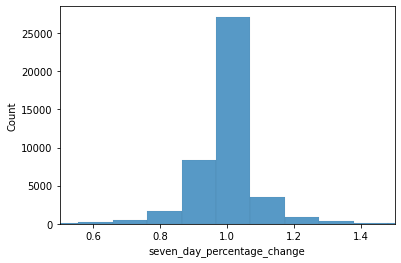

In [ ]:
sns.histplot(data.seven_day_percentage_change, bins = 1000)
plt.xlim(0.5, 1.5)
# plt.ylim(0,2000)

(0.0, 2000.0)

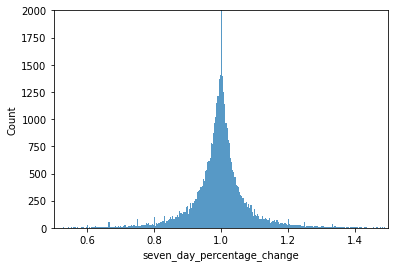

In [ ]:
sns.histplot(data.seven_day_percentage_change)
plt.xlim(0.5, 1.5)
plt.ylim(0,2000)

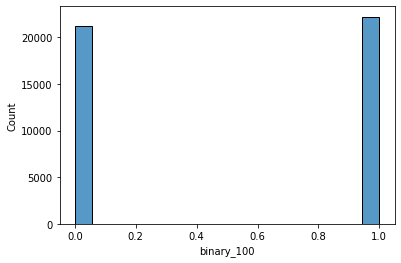

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 100%
#### 0 for percentage changes below 100%
data.loc[data.seven_day_percentage_change < 1,"binary_100"] = 0
data.loc[data.seven_day_percentage_change >= 1,"binary_100"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.binary_100)

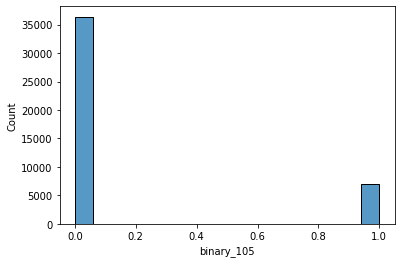

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 105%
#### 0 for percentage changes below 105%
data.loc[data.seven_day_percentage_change < 1.05,"binary_105"] = 0
data.loc[data.seven_day_percentage_change >= 1.05,"binary_105"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.binary_105)

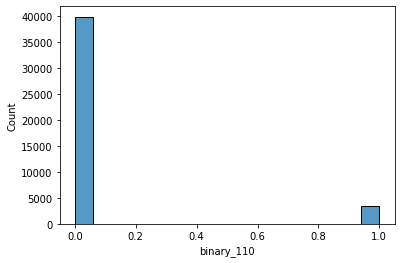

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 110%
#### 0 for percentage changes below 110%
data.loc[data.seven_day_percentage_change < 1.1,"binary_110"] = 0
data.loc[data.seven_day_percentage_change >= 1.1,"binary_110"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.binary_110)

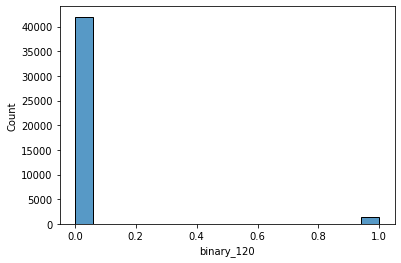

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 120%
#### 0 for percentage changes below 120%
data.loc[data.seven_day_percentage_change < 1.2,"binary_120"] = 0
data.loc[data.seven_day_percentage_change >= 1.2,"binary_120"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.binary_120)

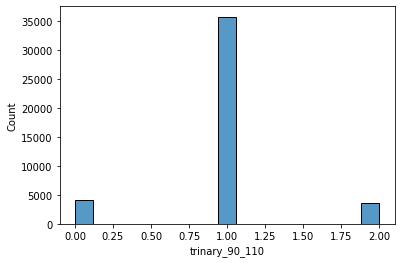

In [ ]:
## Creating Label 
#### 2 for percentage changes >= 110%
#### 1 for percentage changes between 90% and 110%
#### 0 for percentage changes below 90%

data.loc[data.seven_day_percentage_change >= 1.1,"trinary_90_110"] = 2
data.loc[(data.seven_day_percentage_change < 1.1) & (data.seven_day_percentage_change >= 0.9),"trinary_90_110"] = 1
data.loc[data.seven_day_percentage_change < 0.9,"trinary_90_110"] = 0

## plot histogram to check distribution of labels
sns.histplot(data.trinary_90_110)

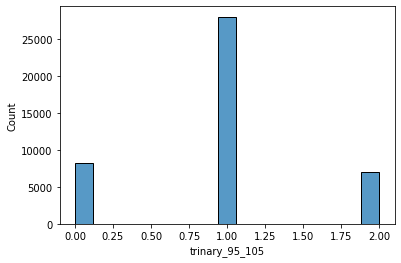

In [ ]:
## Creating Label 
#### 2 for percentage changes >= 105%
#### 1 for percentage changes between 95% and 105%
#### 0 for percentage changes below 95%

data.loc[data.seven_day_percentage_change >= 1.05,"trinary_95_105"] = 2
data.loc[(data.seven_day_percentage_change < 1.05) & (data.seven_day_percentage_change >= 0.95),"trinary_95_105"] = 1
data.loc[data.seven_day_percentage_change < 0.95,"trinary_95_105"] = 0

## plot histogram to check distribution of labels
sns.histplot(data.trinary_95_105)

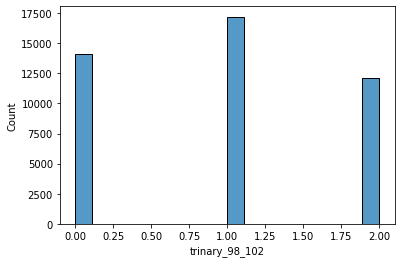

In [ ]:
## Creating Label 
#### 2 for percentage changes >= 102%
#### 1 for percentage changes between 98% and 102%
#### 0 for percentage changes below 98%

data.loc[data.seven_day_percentage_change >= 1.02,"trinary_98_102"] = 2
data.loc[(data.seven_day_percentage_change < 1.02) & (data.seven_day_percentage_change >= 0.98),"trinary_98_102"] = 1
data.loc[data.seven_day_percentage_change < 0.98,"trinary_98_102"] = 0

## plot histogram to check distribution of labels
sns.histplot(data.trinary_98_102)

In [ ]:
data.to_csv('drive/MyDrive/W266 Project/data_augmented_mda_no_numbers_labels.csv', index = False)

## Create new labels - using next day opening price and same day closing price

In [ ]:
data = pd.read_csv('drive/My Drive/W266 Project/data_augmented_mda_no_numbers.csv')

In [ ]:
data.shape

(43400, 21)

In [ ]:
data["next_day_percentage_change"] = data.opening_price_on_next_trading_date / data.closing_price_on_filing_date
data["seven_day_percentage_change"] = data.opening_price_7_days_after / data.closing_price_on_filing_date

data = data.drop(['adsh',
           'cik',
           'accepted_filing_time',
           'mda_raw_text',
           'ending_of_mda',
           'mda_length',
           'full_ten_q_length',
           'mda_percentage',
           'trading_date_30_days_after',
           'opening_price_30_days_after',
           'next_trading_date',
           'opening_price_on_next_trading_date'
           ],
          axis = 1)

(0.5, 1.5)

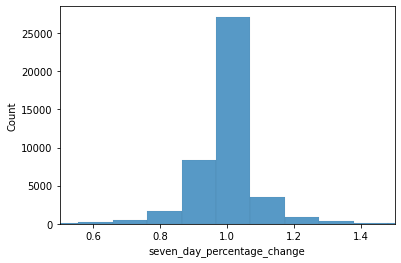

In [ ]:
sns.histplot(data.seven_day_percentage_change, bins = 1000)
plt.xlim(0.5, 1.5)
# plt.ylim(0,2000)

(0.0, 2000.0)

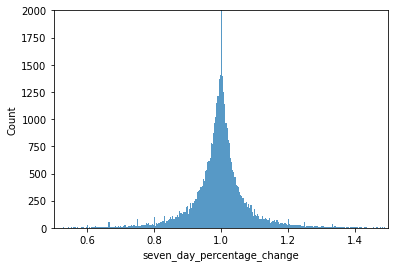

In [ ]:
sns.histplot(data.seven_day_percentage_change)
plt.xlim(0.5, 1.5)
plt.ylim(0,2000)

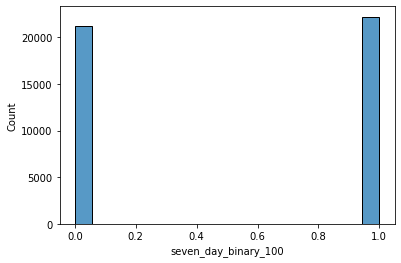

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 100%
#### 0 for percentage changes below 100%
data.loc[data.seven_day_percentage_change < 1,"seven_day_binary_100"] = 0
data.loc[data.seven_day_percentage_change >= 1,"seven_day_binary_100"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.seven_day_binary_100)

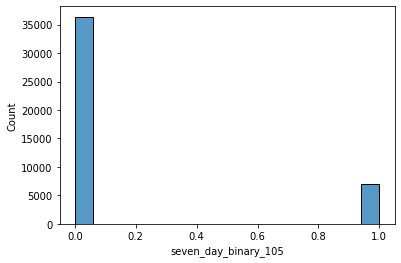

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 105%
#### 0 for percentage changes below 105%
data.loc[data.seven_day_percentage_change < 1.05,"seven_day_binary_105"] = 0
data.loc[data.seven_day_percentage_change >= 1.05,"seven_day_binary_105"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.seven_day_binary_105)

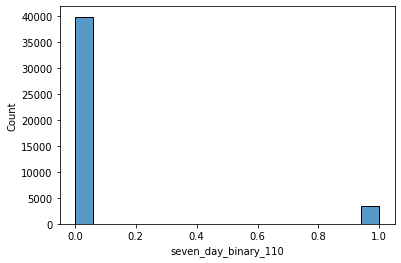

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 110%
#### 0 for percentage changes below 110%
data.loc[data.seven_day_percentage_change < 1.1,"seven_day_binary_110"] = 0
data.loc[data.seven_day_percentage_change >= 1.1,"seven_day_binary_110"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.seven_day_binary_110)

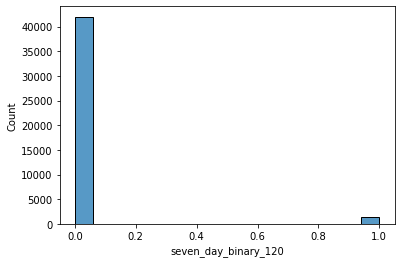

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 120%
#### 0 for percentage changes below 120%
data.loc[data.seven_day_percentage_change < 1.2,"seven_day_binary_120"] = 0
data.loc[data.seven_day_percentage_change >= 1.2,"seven_day_binary_120"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.seven_day_binary_120)

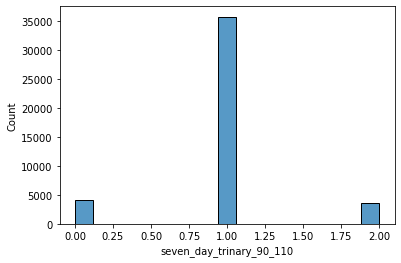

In [ ]:
## Creating Label 
#### 2 for percentage changes >= 110%
#### 1 for percentage changes between 90% and 110%
#### 0 for percentage changes below 90%

data.loc[data.seven_day_percentage_change >= 1.1,"seven_day_trinary_90_110"] = 2
data.loc[(data.seven_day_percentage_change < 1.1) & (data.seven_day_percentage_change >= 0.9),"seven_day_trinary_90_110"] = 1
data.loc[data.seven_day_percentage_change < 0.9,"seven_day_trinary_90_110"] = 0

## plot histogram to check distribution of labels
sns.histplot(data.seven_day_trinary_90_110)

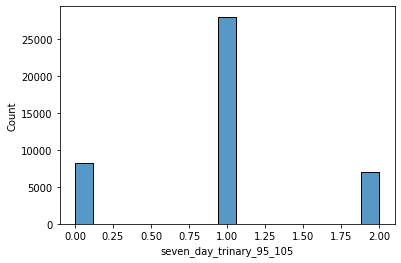

In [ ]:
## Creating Label 
#### 2 for percentage changes >= 105%
#### 1 for percentage changes between 95% and 105%
#### 0 for percentage changes below 95%

data.loc[data.seven_day_percentage_change >= 1.05,"seven_day_trinary_95_105"] = 2
data.loc[(data.seven_day_percentage_change < 1.05) & (data.seven_day_percentage_change >= 0.95),"seven_day_trinary_95_105"] = 1
data.loc[data.seven_day_percentage_change < 0.95,"seven_day_trinary_95_105"] = 0

## plot histogram to check distribution of labels
sns.histplot(data.seven_day_trinary_95_105)

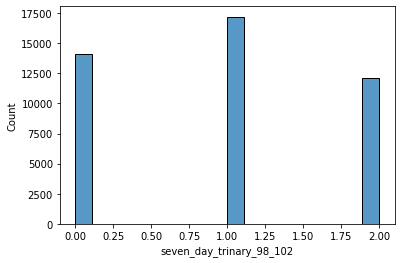

In [ ]:
## Creating Label 
#### 2 for percentage changes >= 102%
#### 1 for percentage changes between 98% and 102%
#### 0 for percentage changes below 98%

data.loc[data.seven_day_percentage_change >= 1.02,"seven_day_trinary_98_102"] = 2
data.loc[(data.seven_day_percentage_change < 1.02) & (data.seven_day_percentage_change >= 0.98),"seven_day_trinary_98_102"] = 1
data.loc[data.seven_day_percentage_change < 0.98,"seven_day_trinary_98_102"] = 0

## plot histogram to check distribution of labels
sns.histplot(data.seven_day_trinary_98_102)

(0.5, 1.5)

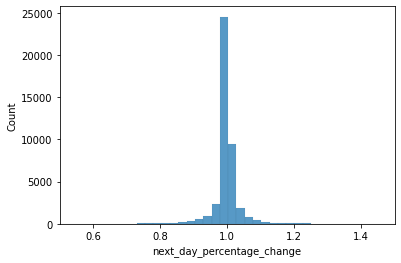

In [ ]:
sns.histplot(data.next_day_percentage_change, bins = 1000)
plt.xlim(0.5, 1.5)
# plt.ylim(0,2000)

(0.0, 1000.0)

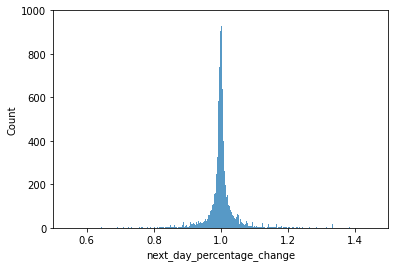

In [ ]:
sns.histplot(data.next_day_percentage_change)
plt.xlim(0.5, 1.5)
plt.ylim(0,1000)

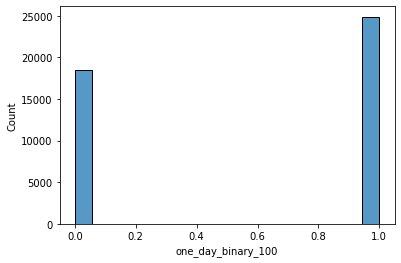

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 100%
#### 0 for percentage changes below 100%
data.loc[data.next_day_percentage_change < 1,"one_day_binary_100"] = 0
data.loc[data.next_day_percentage_change >= 1,"one_day_binary_100"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.one_day_binary_100)

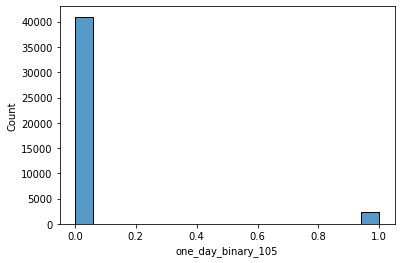

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 105%
#### 0 for percentage changes below 105%
data.loc[data.next_day_percentage_change < 1.05,"one_day_binary_105"] = 0
data.loc[data.next_day_percentage_change >= 1.05,"one_day_binary_105"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.one_day_binary_105)

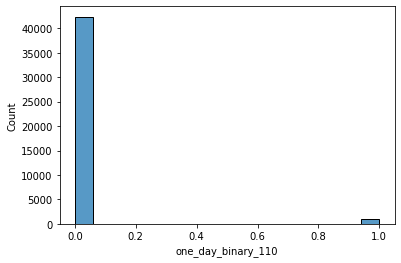

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 110%
#### 0 for percentage changes below 110%
data.loc[data.next_day_percentage_change < 1.1,"one_day_binary_110"] = 0
data.loc[data.next_day_percentage_change >= 1.1,"one_day_binary_110"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.one_day_binary_110)

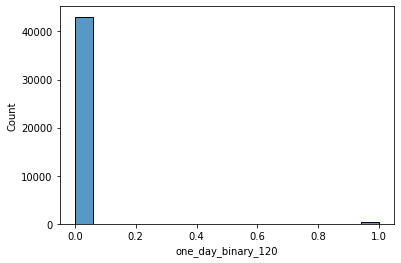

In [ ]:
## Creating Label 
#### 1 for percentage changes >= 120%
#### 0 for percentage changes below 120%
data.loc[data.next_day_percentage_change < 1.2,"one_day_binary_120"] = 0
data.loc[data.next_day_percentage_change >= 1.2,"one_day_binary_120"] = 1

## plot histogram to check distribution of labels
sns.histplot(data.one_day_binary_120)

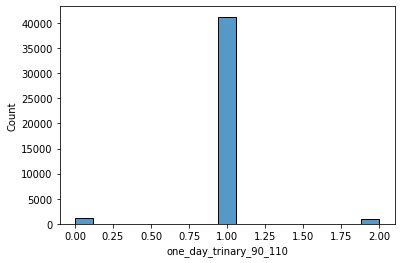

In [ ]:
## Creating Label 
#### 2 for percentage changes >= 110%
#### 1 for percentage changes between 90% and 110%
#### 0 for percentage changes below 90%

data.loc[data.next_day_percentage_change >= 1.1,"one_day_trinary_90_110"] = 2
data.loc[(data.next_day_percentage_change < 1.1) & (data.next_day_percentage_change >= 0.9),"one_day_trinary_90_110"] = 1
data.loc[data.next_day_percentage_change < 0.9,"one_day_trinary_90_110"] = 0

## plot histogram to check distribution of labels
sns.histplot(data.one_day_trinary_90_110)

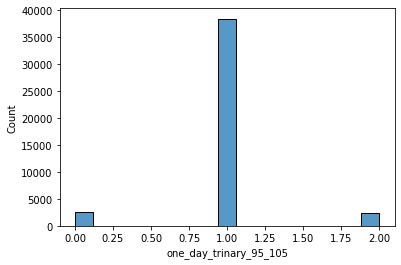

In [ ]:
## Creating Label 
#### 2 for percentage changes >= 105%
#### 1 for percentage changes between 95% and 105%
#### 0 for percentage changes below 95%

data.loc[data.next_day_percentage_change >= 1.05,"one_day_trinary_95_105"] = 2
data.loc[(data.next_day_percentage_change < 1.05) & (data.next_day_percentage_change >= 0.95),"one_day_trinary_95_105"] = 1
data.loc[data.next_day_percentage_change < 0.95,"one_day_trinary_95_105"] = 0

## plot histogram to check distribution of labels
sns.histplot(data.one_day_trinary_95_105)

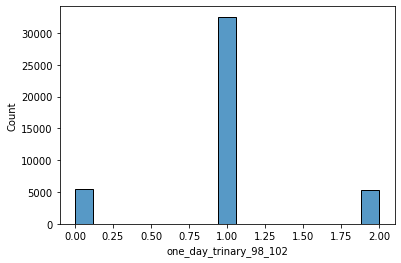

In [ ]:
## Creating Label 
#### 2 for percentage changes >= 102%
#### 1 for percentage changes between 98% and 102%
#### 0 for percentage changes below 98%

data.loc[data.next_day_percentage_change >= 1.02,"one_day_trinary_98_102"] = 2
data.loc[(data.next_day_percentage_change < 1.02) & (data.next_day_percentage_change >= 0.98),"one_day_trinary_98_102"] = 1
data.loc[data.next_day_percentage_change < 0.98,"one_day_trinary_98_102"] = 0

## plot histogram to check distribution of labels
sns.histplot(data.one_day_trinary_98_102)

In [ ]:
data.to_csv('drive/MyDrive/W266 Project/data_augmented_mda_no_numbers_all_labels.csv', index = False)

## Tokenize raw text and save to pickle files

In [ ]:
full_data = pd.read_csv('/content/drive/MyDrive/W266 Project/data_augmented_mda_no_numbers_all_labels.csv')

In [ ]:
print("Full Data set:", full_data.shape, sep = '\n')
print(full_data.seven_day_trinary_98_102.value_counts())
print(full_data.one_day_trinary_98_102.value_counts())
print(full_data.seven_day_binary_100.value_counts())
print(full_data.one_day_binary_100.value_counts())

Full Data set:
(43400, 25)
1.0    17192
0.0    14083
2.0    12125
Name: seven_day_trinary_98_102, dtype: int64
1.0    32538
0.0     5471
2.0     5391
Name: one_day_trinary_98_102, dtype: int64
1.0    22211
0.0    21189
Name: seven_day_binary_100, dtype: int64
1.0    24881
0.0    18519
Name: one_day_binary_100, dtype: int64


In [ ]:
X = full_data.loc[:,['mda_raw_text_no_numbers']]

In [ ]:
Y = full_data.loc[:,['one_day_binary_100',
                     'one_day_binary_105',
                     'one_day_binary_110',
                     'one_day_binary_120',
                     'one_day_trinary_90_110',
                     'one_day_trinary_95_105',
                     'one_day_trinary_98_102',
                     'seven_day_binary_100',
                     'seven_day_binary_105',
                     'seven_day_binary_110',
                     'seven_day_binary_120',
                     'seven_day_trinary_90_110',
                     'seven_day_trinary_95_105',
                     'seven_day_trinary_98_102',
                     ]
                  ]

In [ ]:
# create training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(X, Y, test_size=.2)

In [ ]:
print("Training set:", len(train_labels), sep='\n\n')
print(train_labels.value_counts())

Training set:

34720
one_day_binary_100  one_day_binary_105  one_day_binary_110  one_day_binary_120  one_day_trinary_90_110  one_day_trinary_95_105  one_day_trinary_98_102  seven_day_binary_100  seven_day_binary_105  seven_day_binary_110  seven_day_binary_120  seven_day_trinary_90_110  seven_day_trinary_95_105  seven_day_trinary_98_102
1.0                 0.0                 0.0                 0.0                 1.0                     1.0                     1.0                     1.0                   0.0                   0.0                   0.0                   1.0                       1.0                       1.0                         5057
0.0                 0.0                 0.0                 0.0                 1.0                     1.0                     1.0                     0.0                   0.0                   0.0                   0.0                   1.0                       1.0                       1.0                         2526
1.0         

In [ ]:
print("Testing set:", len(test_labels), sep='\n\n')
print(test_labels.value_counts())

Testing set:

8680
one_day_binary_100  one_day_binary_105  one_day_binary_110  one_day_binary_120  one_day_trinary_90_110  one_day_trinary_95_105  one_day_trinary_98_102  seven_day_binary_100  seven_day_binary_105  seven_day_binary_110  seven_day_binary_120  seven_day_trinary_90_110  seven_day_trinary_95_105  seven_day_trinary_98_102
1.0                 0.0                 0.0                 0.0                 1.0                     1.0                     1.0                     1.0                   0.0                   0.0                   0.0                   1.0                       1.0                       1.0                         1157
0.0                 0.0                 0.0                 0.0                 1.0                     1.0                     1.0                     0.0                   0.0                   0.0                   0.0                   1.0                       1.0                       1.0                          657
1.0           

In [ ]:
## save these so that we can load these in directly without re-randomizing our train and test set

train_texts.to_csv('drive/MyDrive/W266 Project/final_dataset/train_texts.csv', index = False)
train_labels.to_csv('drive/MyDrive/W266 Project/final_dataset/train_labels.csv', index = False)
test_texts.to_csv('drive/MyDrive/W266 Project/final_dataset/test_texts.csv', index = False)
test_labels.to_csv('drive/MyDrive/W266 Project/final_dataset/test_labels.csv', index = False)

In [ ]:
train_texts = pd.read_csv('/content/drive/MyDrive/W266 Project/final_dataset/train_texts.csv')
# train_labels = pd.read_csv('/content/drive/MyDrive/W266 Project/final_dataset/train_labels.csv')
test_texts = pd.read_csv('/content/drive/MyDrive/W266 Project/final_dataset/test_texts.csv')
# test_labels = pd.read_csv('/content/drive/MyDrive/W266 Project/final_dataset/test_labels.csv')

In [ ]:
train_texts = train_texts.iloc[:,0]
test_texts = test_texts.iloc[:,0]
# train_labels = train_labels.iloc[:,0]

train_texts = train_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
# train_labels = train_labels.reset_index(drop=True)

In [ ]:
print(len(train_texts))
print(len(test_texts))
# print(len(test_texts))

34720
8680


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def chunked_tokenize(texts):
    train_texts = texts

    chunk_size = 5000
    total_rows = len(train_texts)
    chunks = range(total_rows // chunk_size + 1)

    for i in chunks:
        if i == 0:
            start = datetime.datetime.now()
            print("Start:", start)

            train_encodings = tokenizer(list(train_texts[i*chunk_size:(i+1)*chunk_size]))

            print("Finished processing rows", i*chunk_size, "through", (i+1)*chunk_size)
            end = datetime.datetime.now()
            print("End:", end)
            print('Duration:', end - start)
            print()

        elif i != chunks[-1]:
            start = datetime.datetime.now()
            print("Start:", start)


            train_encodings_set = tokenizer(list(train_texts[i*chunk_size:(i+1)*chunk_size]))
            train_encodings['input_ids'].extend(train_encodings_set['input_ids'])
            train_encodings['attention_mask'].extend(train_encodings_set['attention_mask'])
            train_encodings['token_type_ids'].extend(train_encodings_set['token_type_ids'])

            print("Finished processing rows", i*chunk_size, "through", (i+1)*chunk_size)
            end = datetime.datetime.now()
            print("End:", end)
            print('Duration:', end - start)
            print()

        else:
            start = datetime.datetime.now()
            print("Start:", start)

            train_encodings_set = tokenizer(list(train_texts[i*chunk_size:]))
            train_encodings['input_ids'].extend(train_encodings_set['input_ids'])
            train_encodings['attention_mask'].extend(train_encodings_set['attention_mask'])
            train_encodings['token_type_ids'].extend(train_encodings_set['token_type_ids'])

            print("Finished processing rows", i*chunk_size, "through END")
            end = datetime.datetime.now()
            print("End:", end)
            print('Duration:', end - start)
            print()
    return train_encodings

In [ ]:
train_encodings = chunked_tokenize(train_texts)
test_encodings = chunked_tokenize(test_texts)

# Store data (serialize)
with open('/content/drive/MyDrive/W266 Project/final_dataset/train_encodings.pickle', 'wb') as handle:
    pickle.dump(train_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/W266 Project/final_dataset/test_encodings.pickle', 'wb') as handle:
    pickle.dump(test_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL) 

Start: 2021-03-31 04:35:32.237554


Token indices sequence length is longer than the specified maximum sequence length for this model (12744 > 512). Running this sequence through the model will result in indexing errors


Finished processing rows 0 through 5000
End: 2021-03-31 04:59:29.651680
Duration: 0:23:57.414126

Start: 2021-03-31 04:59:29.651883
Finished processing rows 5000 through 10000
End: 2021-03-31 05:22:25.917250
Duration: 0:22:56.265367

Start: 2021-03-31 05:22:25.919625
Finished processing rows 10000 through 15000
End: 2021-03-31 05:46:05.212004
Duration: 0:23:39.292379

Start: 2021-03-31 05:46:05.212177
Finished processing rows 15000 through 20000
End: 2021-03-31 06:09:55.799548
Duration: 0:23:50.587371

Start: 2021-03-31 06:09:55.801183
Finished processing rows 20000 through 25000
End: 2021-03-31 06:34:07.336229
Duration: 0:24:11.535046

Start: 2021-03-31 06:34:07.337981
Finished processing rows 25000 through 30000
End: 2021-03-31 06:56:39.731432
Duration: 0:22:32.393451

Start: 2021-03-31 06:56:39.734481
Finished processing rows 30000 through END
End: 2021-03-31 07:19:23.057079
Duration: 0:22:43.322598

Start: 2021-03-31 07:19:23.069282
Finished processing rows 0 through 5000
End: 2021

In [ ]:
# Store data (serialize)
# with open('/content/drive/MyDrive/W266 Project/train_encodings.pickle', 'wb') as handle:
#     pickle.dump(train_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/MyDrive/W266 Project/test_encodings.pickle', 'wb') as handle:
#     pickle.dump(test_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)    

# # Load data (deserialize)
# with open('filename.pickle', 'rb') as handle:
#     unserialized_data = pickle.load(handle)

# print(your_data == unserialized_data)

In [ ]:
# Load data (deserialize)
with open('/content/drive/MyDrive/W266 Project/train_encodings.pickle', 'rb') as handle:
    train_pickle = pickle.load(handle)

In [ ]:
!nvidia-smi

Tue Mar 30 14:40:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import sys
sys.getsizeof(train_pickle)

64

## Tokenize and get sentence and token counts
Split up into 4 different chunks to not run into RAM issues

In [ ]:
# data = pd.read_csv('drive/My Drive/W266 Project/data_augmented_mda_no_numbers_labels.csv')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def count_sentences(string):
    return string.count(".")

def create_token_word_list(string):
    return tokenizer.tokenize(string)

def create_token_input_ids(string):
    return tokenizer(string)

def count_tokens(token_list):
    return len(token_list)

In [ ]:
chunk_size = 5000
total_rows = data.shape[0]
chunks = range(total_rows // chunk_size + 1)
for i in chunks:
    if i != chunks[-1]:
        start = datetime.datetime.now()
        print("Start:", start)

        data.loc[i*chunk_size:(i+1)*chunk_size,"sentence_count"] = data.loc[i*chunk_size:(i+1)*chunk_size,"mda_raw_text_no_numbers"].apply(count_sentences)
        data.loc[i*chunk_size:(i+1)*chunk_size,"tokens"] = data.loc[i*chunk_size:(i+1)*chunk_size,"mda_raw_text_no_numbers"].apply(create_token_input_ids)
        data.loc[i*chunk_size:(i+1)*chunk_size,"token_count"] = data.loc[i*chunk_size:(i+1)*chunk_size,"tokens"].apply(lambda x: len(x['input_ids']))
        print("Finished processing rows", i*chunk_size, "through", (i+1)*chunk_size)
        
        end = datetime.datetime.now()
        print("End:", end)
        print('Duration:', end - start)
        print()
    else:
        start = datetime.datetime.now()
        print("Start:", start)

        data.loc[i*chunk_size:,"sentence_count"] = data.loc[i*chunk_size:,"mda_raw_text_no_numbers"].apply(count_sentences)
        data.loc[i*chunk_size:,"tokens"] = data.loc[i*chunk_size:,"mda_raw_text_no_numbers"].apply(create_token_input_ids)
        data.loc[i*chunk_size:,"token_count"] = data.loc[i*chunk_size:,"tokens"].apply(lambda x: len(x['input_ids']))
        print("Finished processing rows", i*chunk_size, "through END")
        print(datetime.datetime.now())

        end = datetime.datetime.now()
        print("End:", end)
        print('Duration:', end - start)
        print()

data.to_csv('drive/MyDrive/W266 Project/data_augmented_mda_no_numbers_labels_tokens.csv', index = False)

Token indices sequence length is longer than the specified maximum sequence length for this model (2324 > 512). Running this sequence through the model will result in indexing errors


Start: 2021-03-20 20:06:50.069396
Finished processing rows 0 through 5000
End: 2021-03-20 20:17:32.559375
Duration: 0:10:42.489979

Start: 2021-03-20 20:17:32.559523
Finished processing rows 5000 through 10000
End: 2021-03-20 20:33:53.517538
Duration: 0:16:20.958015

Start: 2021-03-20 20:33:53.517717
Finished processing rows 10000 through 15000
End: 2021-03-20 20:50:42.429628
Duration: 0:16:48.911911

Start: 2021-03-20 20:50:42.429756
Finished processing rows 15000 through 20000
End: 2021-03-20 21:10:53.633763
Duration: 0:20:11.204007

Start: 2021-03-20 21:10:53.667294
Finished processing rows 20000 through 25000
End: 2021-03-20 21:31:08.161566
Duration: 0:20:14.494272

Start: 2021-03-20 21:31:08.161720
Finished processing rows 25000 through 30000
End: 2021-03-20 21:51:22.372217
Duration: 0:20:14.210497

Start: 2021-03-20 21:51:22.372428
Finished processing rows 30000 through 35000
End: 2021-03-20 22:10:59.877312
Duration: 0:19:37.504884

Start: 2021-03-20 22:10:59.877433
Finished proc

In [ ]:
data.shape

(43400, 20)

In [ ]:
data.head()

,ticker,name,sec_url,accepted_filing_date,trading_date_closest_to_filing_date,closing_price_on_filing_date,trading_date_7_days_after,opening_price_7_days_after,mda_raw_text_no_numbers,seven_day_percentage_change,binary_100,binary_105,binary_110,binary_120,trinary_90_110,trinary_95_105,trinary_98_102,sentence_count,tokens,token_count
0,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2017-11-14,2017-11-14,13.238575,2017-11-21,12.868580,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,0.972052,0.0,0.0,0.0,0.0,1.0,1.0,0.0,82.0,"[input_ids, token_type_ids, attention_mask]",2324.0
1,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2020-05-12,2020-05-12,9.800000,2020-05-19,10.300000,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,1.051020,1.0,1.0,0.0,0.0,1.0,2.0,2.0,98.0,"[input_ids, token_type_ids, attention_mask]",3130.0
2,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2020-02-11,2020-02-11,15.650000,2020-02-18,15.200000,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,0.971246,0.0,0.0,0.0,0.0,1.0,1.0,0.0,83.0,"[input_ids, token_type_ids, attention_mask]",2544.0
3,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2016-05-10,2016-05-10,12.162181,2016-05-17,12.204263,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,1.003460,1.0,0.0,0.0,0.0,1.0,1.0,1.0,87.0,"[input_ids, token_type_ids, attention_mask]",2528.0
4,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2016-02-09,2016-02-09,11.319373,2016-02-16,11.385911,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,1.005878,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,"[input_ids, token_type_ids, attention_mask]",2498.0


## EDA on sentence and token count

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/W266 Project/data_augmented_mda_no_numbers_labels_tokens.csv')

(0.0, 30000.0)

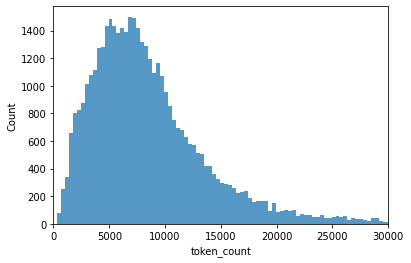

In [ ]:
sns.histplot(data.token_count)
plt.xlim(0,30000)

(0.0, 30000.0)

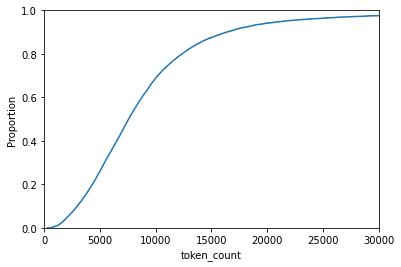

In [ ]:
sns.ecdfplot(data.token_count)
plt.xlim(0,30000)

## Create Final Dataset and drop raw text column for space

In [ ]:
# data = pd.read_csv('drive/My Drive/W266 Project/data_augmented_mda_no_numbers_labels_tokens.csv')

In [ ]:
data.head()

,ticker,name,sec_url,accepted_filing_date,trading_date_closest_to_filing_date,closing_price_on_filing_date,trading_date_7_days_after,opening_price_7_days_after,mda_raw_text_no_numbers,seven_day_percentage_change,binary_100,binary_105,binary_110,binary_120,trinary_90_110,trinary_95_105,trinary_98_102,sentence_count,tokens,token_count
0,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2017-11-14,2017-11-14,13.238575,2017-11-21,12.868580,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,0.972052,0.0,0.0,0.0,0.0,1.0,1.0,0.0,82.0,"[input_ids, token_type_ids, attention_mask]",2324.0
1,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2020-05-12,2020-05-12,9.800000,2020-05-19,10.300000,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,1.051020,1.0,1.0,0.0,0.0,1.0,2.0,2.0,98.0,"[input_ids, token_type_ids, attention_mask]",3130.0
2,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2020-02-11,2020-02-11,15.650000,2020-02-18,15.200000,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,0.971246,0.0,0.0,0.0,0.0,1.0,1.0,0.0,83.0,"[input_ids, token_type_ids, attention_mask]",2544.0
3,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2016-05-10,2016-05-10,12.162181,2016-05-17,12.204263,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,1.003460,1.0,0.0,0.0,0.0,1.0,1.0,1.0,87.0,"[input_ids, token_type_ids, attention_mask]",2528.0
4,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2016-02-09,2016-02-09,11.319373,2016-02-16,11.385911,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,1.005878,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,"[input_ids, token_type_ids, attention_mask]",2498.0


In [ ]:
## drop raw text column
data = data.drop(['mda_raw_text_no_numbers'
           ],
          axis = 1)

In [ ]:
data.to_csv('drive/MyDrive/W266 Project/final_dataset.csv', index = False)

## Create Train and Test Datasets

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(data.tokens, data.binary_100, test_size=.2)

train_data = pd.concat([train_texts, train_labels], axis = 1)
test_data = pd.concat([test_texts, test_labels], axis = 1)

train_data.to_csv('/content/drive/MyDrive/W266 Project/final_dataset/train_data.csv', index = False)
test_data.to_csv('/content/drive/MyDrive/W266 Project/final_dataset/test_data.csv', index = False)

In [ ]:
train_data.to_pickle('/content/drive/MyDrive/W266 Project/train_data.pkl')
test_data.to_pickle('/content/drive/MyDrive/W266 Project/test_data.pkl')

## Sandbox

In [ ]:
import pandas as pd

pickle_train = pd.read_pickle("/content/drive/MyDrive/W266 Project/train_data.pkl")

In [ ]:
print(4 + 4)